***Libraries***

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import model_from_json
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import os
from dateutil.relativedelta import relativedelta
from datetime import date, timedelta, datetime
import itertools
import torch
from collections import Counter
plt.style.use('fivethirtyeight')
from google.colab import drive
drive.mount('/content/gdrive')
print('Libraries imported and Drive mounted !')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Libraries imported and Drive mounted !


***Data*** ***Filtering***

In [ ]:
#Get the stock quote 
df = web.DataReader('BTC-USD', data_source='yahoo', start='2019-09-20', end='2020-09-20')

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
#Scale the all of the data to be values between 0 and 1 
global scaled_data
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

***agents*** ***class's***

In [ ]:
class Ragent:
 
  id = 'r'
 
  def __init__(self, training_data_len):
 
    self.training_data_len = training_data_len
 
    #DATA INTEGRATION
    #Create the scaled training data set 
    train_data = scaled_data[0:training_data_len  , : ]
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(60,len(train_data)):
        x_train.append(train_data[i-60:i,0])
        y_train.append(train_data[i,0])
    #Convert x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    #Reshape the data into the shape accepted by the LSTM
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    #Test data set
    test_data = scaled_data[training_data_len - 60: , : ]
    #Create the x_test and y_test data sets
    x_test = []
    y_test =  dataset[training_data_len : , : ]
    for i in range(60,len(test_data)):
      x_test.append(test_data[i-60:i,0])
    #Convert x_test to a numpy array 
    x_test = np.array(x_test)
    #Reshape the data into the shape accepted by the LSTM
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test
  
  def build_model(self):
 
    #Build the LSTM network model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True,input_shape=(self.x_train.shape[1],1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    return model
 
  def train(self, scaled_data ):
 
    model = self.build_model()
    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    #Train the model
    model.fit(self.x_train, self.y_train, batch_size=1, epochs=10)
    #Getting the models predicted price values
    predictions = model.predict(self.x_test) 
    predictions = scaler.inverse_transform(predictions)
    #saving the model
    # serialize model to JSON
    model_json = model.to_json()
    with open("./gdrive/My Drive/Models/rmodel.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("./gdrive/My Drive/Models/rmodel.h5")
    print("Saved model to disk")
    return predictions
 
  def load(self):
 
    # load json and create model
    json_file = open("./gdrive/My Drive/Models/rmodel.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("./gdrive/My Drive/Models/rmodel.h5")
    print("Loaded model from disk")
    return loaded_model
    
  def showGraph(self, predictions):
 
    #Plot/Create the data for the graph
    train = data[:self.training_data_len]
    valid = data[self.training_data_len:]
    valid['Predictions'] = predictions
    #Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price BTC/USD ($)', fontsize=18)
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Val', 'Predictions'], loc='lower right')
    plt.show()
 
 
  def predict(self, start , end):
 
    #getting the range of days prior to the start
    today = datetime.strptime(start, '%Y-%m-%d')
    two_m_ago = today - relativedelta(months=3)
    start = two_m_ago.strftime('%Y-%m-%d')
    #loading the model
    model = self.load()
    #Get the quote
    btc_quote = web.DataReader('BTC-USD', data_source='yahoo', start=start, end=end)
    #Create a new dataframe
    new_df = btc_quote.filter(['Close'])
    #Get teh last 60 day closing price 
    last_60_days = new_df[-60:].values
    #Scale the data to be values between 0 and 1
    last_60_days_scaled = scaler.transform(last_60_days)
    #Create an empty list
    X_test = []
    #Append the past 60 days
    X_test.append(last_60_days_scaled)
    #Convert the X_test data set to a numpy array
    X_test = np.array(X_test)
    #Reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #Get the predicted scaled price
    pred_price = model.predict(X_test)
    #undo the scaling 
    pred_price = scaler.inverse_transform(pred_price)
    pred_price = pred_price[0]
    pred_price = pred_price[0]
    return pred_price

In [ ]:
class Eagent:
 
  id = 'e'
 
  def __init__(self, training_data_len, C):
 
    #The agent represent a newbie stock market trader who goes by emotions, so we have an "C" as a confidence parameter which represents whether the agent is confident or not
    #C = 1.2      agent is confident
    #C = 1.8      agent is more confident
    #C = -1.8     agent is not confident 
    #c = -1.2     agent is less confident
    #picking the confidence level
    self.C = C 
    self.training_data_len = training_data_len
 
    #DATA INTEGRATION
    #Create the scaled training data set 
    train_data = scaled_data[0:training_data_len  , : ]
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(40,len(train_data)):
        x_train.append(train_data[i-40:i,0])
        y_train.append(train_data[i,0])
    #Convert x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    #Reshape the data into the shape accepted by the LSTM
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    #Test data set
    test_data = scaled_data[training_data_len - 40: , : ]
    #Create the x_test and y_test data sets
    x_test = []
    y_test =  dataset[training_data_len : , : ]
    for i in range(40,len(test_data)):
      x_test.append(test_data[i-40:i,0])
    #Convert x_test to a numpy array 
    x_test = np.array(x_test)
    #Reshape the data into the shape accepted by the LSTM
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test
  
  def build_model(self):
 
    #Build the LSTM network model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True,input_shape=(self.x_train.shape[1],1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    return model
 
  def train(self, scaled_data ):
 
    model = self.build_model()
    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    #Train the model
    model.fit(self.x_train, self.y_train, batch_size=1, epochs=10)
    #Getting the models predicted price values
    predictions = model.predict(self.x_test) 
    predictions = scaler.inverse_transform(predictions)
    #saving the model
    # serialize model to JSON
    model_json = model.to_json()
    with open("./gdrive/My Drive/Models/emodel.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("./gdrive/My Drive/Models/emodel.h5")
    print("Saved model to disk")
    return predictions
 
  def load(self):
 
    # load json and create model
    json_file = open("./gdrive/My Drive/Models/emodel.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("./gdrive/My Drive/Models/emodel.h5")
    print("Loaded model from disk")
    return loaded_model
    
  def showGraph(self, predictions):
 
    #Plot/Create the data for the graph
    train = data[:self.training_data_len]
    valid = data[self.training_data_len:]
    valid['Predictions'] = predictions
    #Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price BTC/USD ($)', fontsize=18)
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Val', 'Predictions'], loc='lower right')
    plt.show()
 
 
  def predict(self, start , end):
 
    #getting the range of days prior to the start
    today = datetime.strptime(start, '%Y-%m-%d')
    two_m_ago = today - relativedelta(months=3)
    start = two_m_ago.strftime('%Y-%m-%d')
    #loading the model
    model = self.load()
    #Get the quote
    btc_quote = web.DataReader('BTC-USD', data_source='yahoo', start=start, end=end)
    #Create a new dataframe
    new_df = btc_quote.filter(['Close'])
    #Get teh last 40 day closing price 
    last_40_days = new_df[-40:].values
    #Scale the data to be values between 0 and 1
    last_40_days_scaled = scaler.transform(last_40_days)
    #Create an empty list
    X_test = []
    #Append the past 40 days
    X_test.append(last_40_days_scaled)
    #Convert the X_test data set to a numpy array
    X_test = np.array(X_test)
    #Reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #Get the predicted scaled price
    pred_price = model.predict(X_test)
    #undo the scaling 
    pred_price = scaler.inverse_transform(pred_price)
    pred_price = pred_price[0]
    pred_price = pred_price[0]
    return pred_price
    

In [ ]:
class Magent:
 
  id = 'm'
 
  def __init__(self, training_data_len):
    self.training_data_len = training_data_len
 
    #DATA INTEGRATION
    #Create the scaled training data set 
    train_data = scaled_data[0:training_data_len  , : ]
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(20,len(train_data)):
        x_train.append(train_data[i-20:i,0])
        y_train.append(train_data[i,0])
    #Convert x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    #Reshape the data into the shape accepted by the LSTM
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    #Test data set
    test_data = scaled_data[training_data_len - 20: , : ]
    #Create the x_test and y_test data sets
    x_test = []
    y_test =  dataset[training_data_len : , : ]
    for i in range(20,len(test_data)):
      x_test.append(test_data[i-20:i,0])
    #Convert x_test to a numpy array 
    x_test = np.array(x_test)
    #Reshape the data into the shape accepted by the LSTM
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test
  
  def build_model(self):
 
    #Build the LSTM network model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True,input_shape=(self.x_train.shape[1],1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    return model
 
  def train(self, scaled_data ):
 
    model = self.build_model()
    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    #Train the model
    model.fit(self.x_train, self.y_train, batch_size=1, epochs=10)
    #Getting the models predicted price values
    predictions = model.predict(self.x_test) 
    predictions = scaler.inverse_transform(predictions)
    #saving the model
    # serialize model to JSON
    model_json = model.to_json()
    with open("./gdrive/My Drive/Models/mmodel.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("./gdrive/My Drive/Models/mmodel.h5")
    print("Saved model to disk")
    return predictions
 
  def load(self):
 
    # load json and create model
    json_file = open("./gdrive/My Drive/Models/mmodel.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("./gdrive/My Drive/Models/mmodel.h5")
    print("Loaded model from disk")
    return loaded_model
    
  def showGraph(self, predictions):
 
    #Plot/Create the data for the graph
    train = data[:self.training_data_len]
    valid = data[self.training_data_len:]
    valid['Predictions'] = predictions
    #Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price BTC/USD ($)', fontsize=18)
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Val', 'Predictions'], loc='lower right')
    plt.show()
 
 
  def predict(self, start , end):
 
    #getting the range of days prior to the start
    today = datetime.strptime(start, '%Y-%m-%d')
    two_m_ago = today - relativedelta(months=3)
    start = two_m_ago.strftime('%Y-%m-%d')
    #loading the model
    model = self.load()
    #Get the quote
    btc_quote = web.DataReader('BTC-USD', data_source='yahoo', start=start, end=end)
    #Create a new dataframe
    new_df = btc_quote.filter(['Close'])
    #Get teh last 20 day closing price 
    last_20_days = new_df[-20:].values
    #Scale the data to be values between 0 and 1
    last_20_days_scaled = scaler.transform(last_20_days)
    #Create an empty list
    X_test = []
    #Append the past 20 days
    X_test.append(last_20_days_scaled)
    #Convert the X_test data set to a numpy array
    X_test = np.array(X_test)
    #Reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #Get the predicted scaled price
    pred_price = model.predict(X_test)
    #undo the scaling 
    pred_price = scaler.inverse_transform(pred_price)
    pred_price = pred_price[0]
    pred_price = pred_price[0]
    return pred_price

***Environment*** ***Class***

In [ ]:
class Env:
 
  def getAction(self, agent, start, end):
 
    pred_price = agent.predict(start, end)
    #Get the quote
    btc_quote2 = web.DataReader('BTC-USD', data_source='yahoo', start=start, end=end)
    real_price = np.array(btc_quote2.filter(['Close']))
    real_price = real_price[0]
    real_price = real_price[0]
    #error ratio
    e = (pred_price - real_price)/real_price
    e = e * 100
    #Action
    if (agent.id == 'r'):
      if e<-2:
        action = "Sell"
        #to verify!
              elif e>2:
        action = "Buy"
      else:
        action = "Hold"
      return action
    #Action
    elif (agent.id == 'e'):
      C = agent.C
      e = e * C
      if e<-2:
        action = "Sell"
      elif e>2:
        action = "Buy"
      else:
        action = "Hold"
      return action
 
  def period(self):   
 
    start = input('Enter the start date of trading of format (%Y-%M-%D): ')
    end = input('Enter the end date of trading of format (%Y-%M-%D): ')
    dayslist = pd.date_range(start=start,end=end).strftime('%Y-%m-%d').tolist()
    return dayslist
 
  def run_stock(self, ragent, eagent, magent, dayslist):
 
    Ractions = []
    Eactions = []
    Mactions = []
    Ragents = []
    Eagents = []
    Magents = []
    #Creating agents
    for i in range(0, ragent):
      r=Ragent(training_data_len)
      Ragents.append(r)
    for i in range(0, eagent):
      C = float(input('Enter the '+str(i)+' emotional agent value between (-1.2/-1.8/1.2/1.8): '))
      e=Eagent(training_data_len, C)
      Eagents.append(e)
    for i in range(0, magent):
      m=Magent(training_data_len)
      Magents.append(m)
    #Running the trading
    for i in range(0, len(dayslist)):
      for ri in range(0, ragent):
        action = self.getAction(Ragents[ri], dayslist[i], dayslist[i])
        Ractions.append(action)
      for ei in range(0, eagent):
        action = self.getAction(Eagents[ei], dayslist[i],dayslist[i])
        Eactions.append(action)
      for mi in range(0, magent):
        action = self.getAction(Magents[mi], dayslist[i],dayslist[i]) 
    allList = list(itertools.chain(Ractions, Eactions, Mactions))
    #Find most frequent action in the actions list  
    mf = max(set(allList), key = allList.count) 
    for i in range(0, (eagent * len(dayslist))):
      allList.append(mf)
    print(allList)
    count = Counter(allList)
    df = pd.DataFrame.from_dict(count, orient='index')
    df.plot(kind='bar')
    plt.title('Agents actions in the period from ' + str(dayslist[0]) + ' to '+ str(dayslist[-1]))
    plt.xlabel('Actions', fontsize=18)
    plt.ylabel('Agents', fontsize=18)
    plt.show()

In [ ]:
r=Ragent(training_data_len)

In [ ]:
#model stats
model = r.load()
model.summary()

Loaded model from disk
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


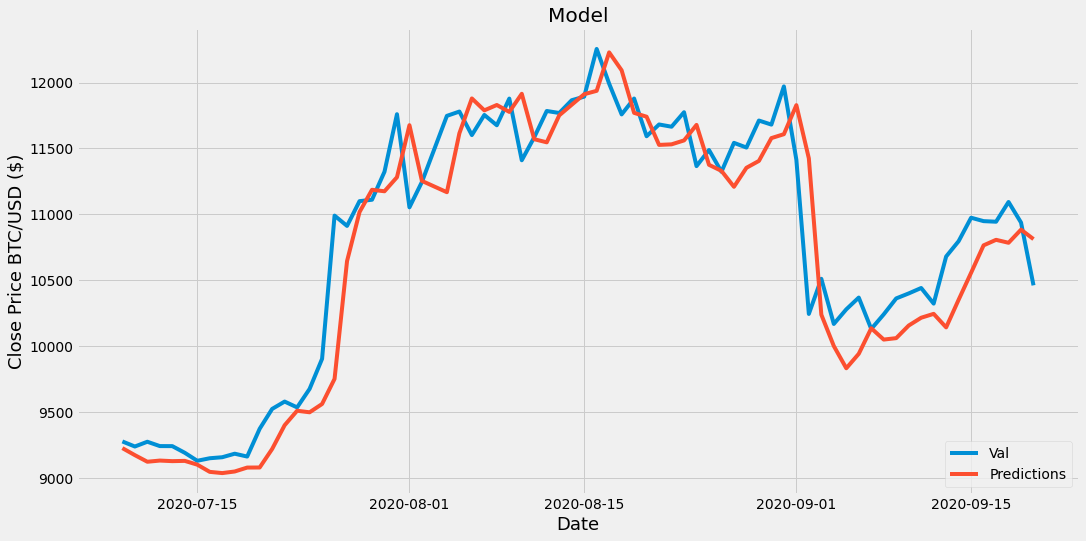

In [ ]:
r.showGraph(predictions)

In [ ]:
r.predict('2020-09-20' ,'2020-09-20')

Loaded model from disk


10393.899

In [ ]:
e=Eagent(training_data_len, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


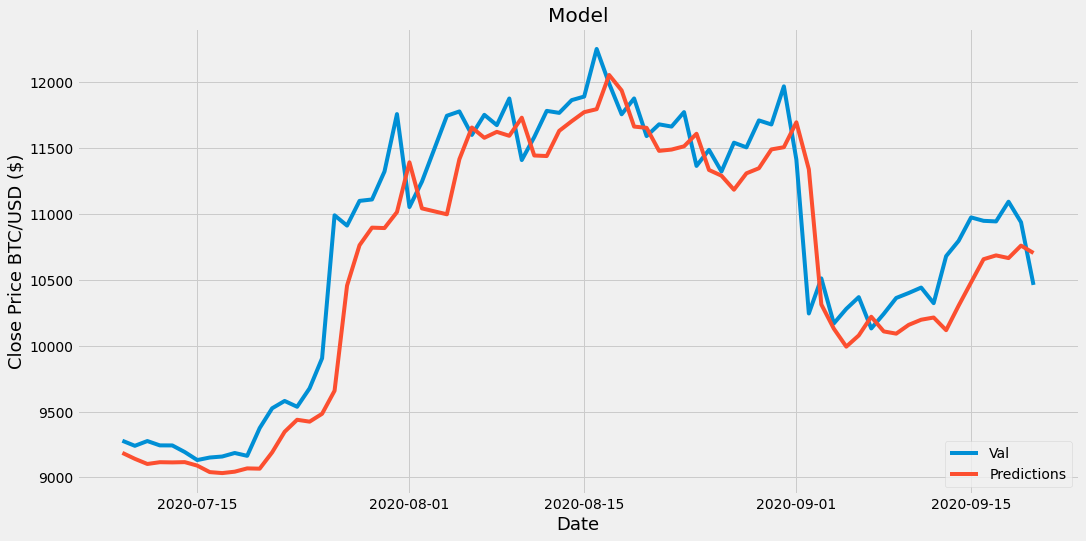

In [ ]:
e.showGraph(predictions)

In [ ]:
e.predict('2020-09-20', '2020-09-20')

Loaded model from disk


10910.037

In [ ]:
m=Magent(training_data_len)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


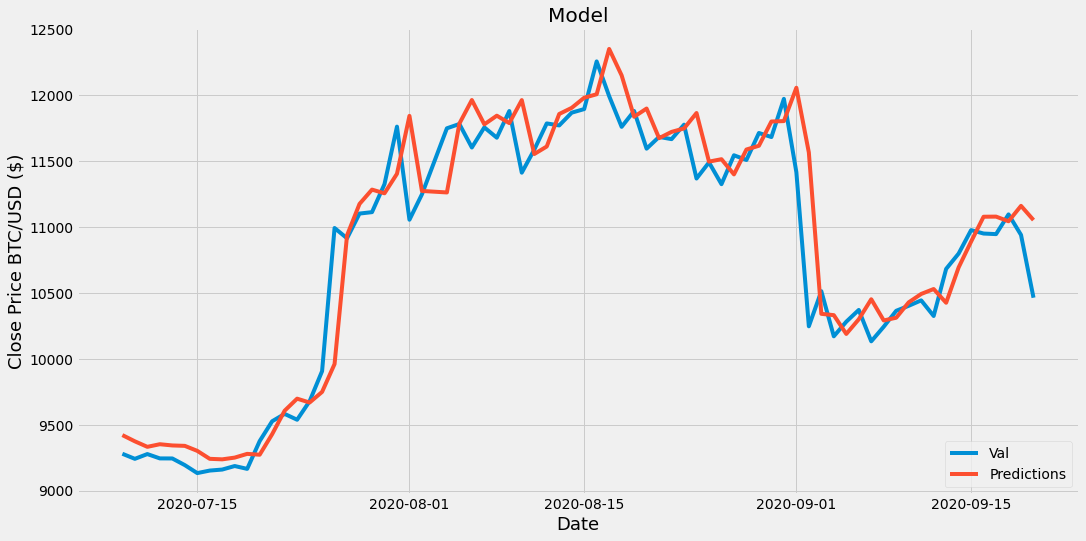

In [ ]:
m.showGraph(predictions)

In [ ]:
m.predict('2020-09-20' ,'2020-09-20')

Loaded model from disk


Enter the start date of trading of format (%Y-%M-%D): 2020-09-17
Enter the end date of trading of format (%Y-%M-%D): 2020-09-18
Enter the 0 emotional agent value between (-1.2/-1.8/1.2/1.8): 1.2
Enter the 1 emotional agent value between (-1.2/-1.8/1.2/1.8): -1.2
Enter the 2 emotional agent value between (-1.2/-1.8/1.2/1.8): -1.8
Enter the 3 emotional agent value between (-1.2/-1.8/1.2/1.8): 1.8
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
['Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Bu

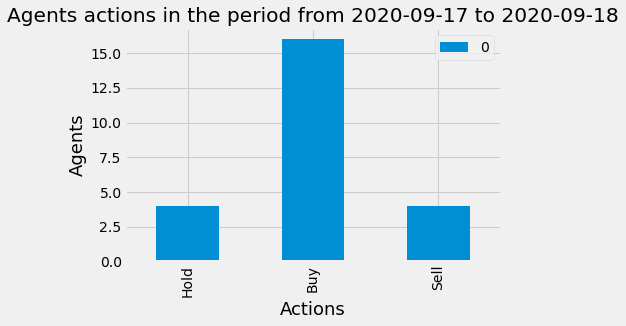

In [ ]:
env=Env()
#env.getAction(e, '2019-09-17' ,'2020-09-17')
env.run_stock(4,4,4, env.period())